<a href="https://colab.research.google.com/github/olhaishchenko/-data_science/blob/master/HW_8_tensorflow_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


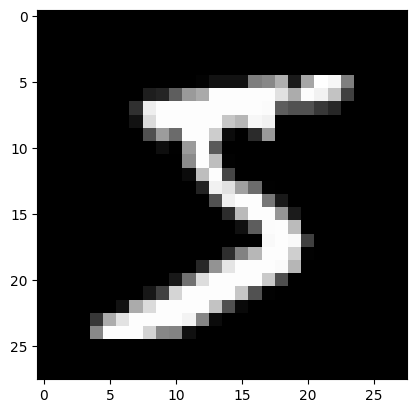

In [4]:
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")

In [5]:
# Создадим нейронную сеть
class DenseLayer(tf.Module):
    def __init__(self, _in, _out, name=None, activation="relu"):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([_in, _out], stddev=0.05), name="w")
        self.b = tf.Variable(tf.zeros([_out]), name="b")
        self.activation = activation

    def __call__(self, x):
        y_in = tf.matmul(x, self.w) + self.b
        if self.activation == "relu":
            y = tf.nn.relu(y_in)
        if self.activation == "softmax":
            y = tf.nn.softmax(y_in)

        return y

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name)
        self.layer_1 = DenseLayer(_in=28*28, _out=n_hidden_1)
        self.layer_2 = DenseLayer(_in=n_hidden_1, _out=n_hidden_2)
        self.layer_3 = DenseLayer(_in=n_hidden_2, _out=10, activation="softmax")

    def __call__(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [6]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(
        tf.argmax(y_pred, 1),
        tf.cast(y_true, tf.int64)
    )
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [7]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    nn_variables = nn.variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, nn.variables)

    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, nn.variables))

    return pred

In [8]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data):
    # Обновляем веса нейронной сети
    pred = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
      cross = cross_entropy(pred, batch_y)
      acc = accuracy(pred, batch_y)
      loss_history.append(cross)
      accuracy_history.append(acc)
      print(f"{step}, {cross._numpy()=} , {acc._numpy()=}")

    if step > training_steps:
      print(f"End training after {training_steps} steps")
      break
        # pred = neural_net(batch_x)


0, cross._numpy()=589.7633 , acc._numpy()=0.11328125
100, cross._numpy()=104.28486 , acc._numpy()=0.89453125
200, cross._numpy()=70.69139 , acc._numpy()=0.9140625
300, cross._numpy()=57.85286 , acc._numpy()=0.92578125
400, cross._numpy()=33.2813 , acc._numpy()=0.96484375
500, cross._numpy()=54.890404 , acc._numpy()=0.921875
600, cross._numpy()=39.005295 , acc._numpy()=0.95703125
700, cross._numpy()=30.802572 , acc._numpy()=0.96875
800, cross._numpy()=31.291214 , acc._numpy()=0.9765625
900, cross._numpy()=18.71899 , acc._numpy()=0.9765625
1000, cross._numpy()=25.363617 , acc._numpy()=0.96875
1100, cross._numpy()=36.207405 , acc._numpy()=0.953125
1200, cross._numpy()=29.624332 , acc._numpy()=0.96875
1300, cross._numpy()=14.450079 , acc._numpy()=0.98828125
1400, cross._numpy()=19.989317 , acc._numpy()=0.97265625
1500, cross._numpy()=20.807909 , acc._numpy()=0.98046875
1600, cross._numpy()=33.593914 , acc._numpy()=0.9609375
1700, cross._numpy()=17.370502 , acc._numpy()=0.9765625
1800, cros

KeyboardInterrupt: ignored

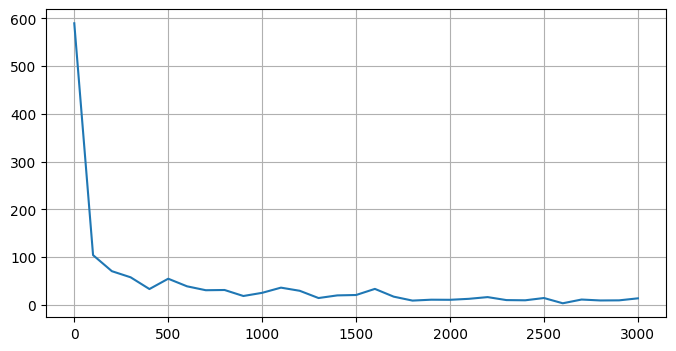

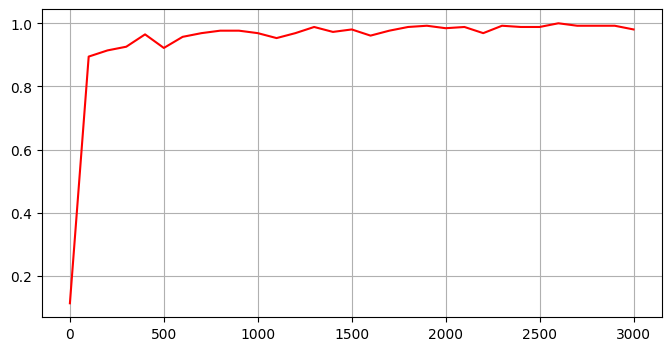

In [12]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, 3000, 31), loss_history)
plt.grid()

plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, 3000, 31), accuracy_history, c="red")
plt.grid()

In [17]:
# Вычислите точность обученной нейросети

pred_test = neural_net(x_test).numpy()
test_acc = accuracy(pred_test, y_test)
print(f"Accuracy of model with test data: Accuracy = {test_acc.numpy():.3f}")

Accuracy of model with test data: Accuracy = 0.977


In [ ]:
y_pred_test = pred_test.argmax(axis=1)

Accuracy = 0.90


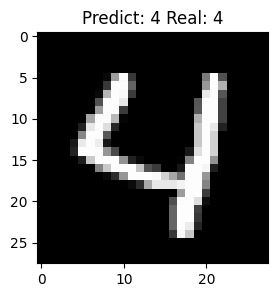

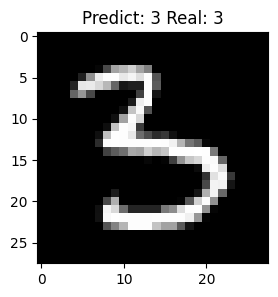

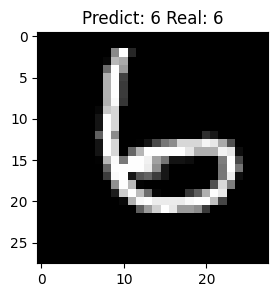

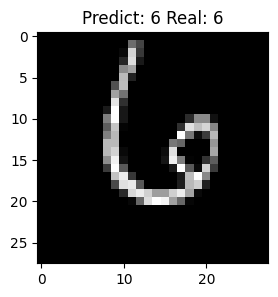

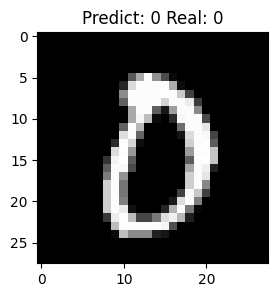

In [40]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

rand_idx = np.random.choice(len(x_test), 10, replace=False)
x_test_10 = x_test[rand_idx]
y_test_10 = y_test[rand_idx]
pred_10 = neural_net(x_test_10).numpy()
acc_10 = accuracy(pred_10, y_test_10)
pred_10 = pred_10.argmax(axis=1)

for i in range(5):
    plt.figure(figsize=(3, 3))
    plt.imshow(x_test_10[i].reshape(28, 28), cmap="gray")
    plt.title(f"Predict: {pred_10[i]} Real: {y_test_10[i]}")
    plt.show
print(f"Accuracy = {acc_10.numpy():.2f}")


Нейрона мережа помиляється лише з цифрою 6. Найкращі дані були на 1800 кроці

In [15]:
import pandas as pd

In [22]:
ea = pd.DataFrame({"pred": y_pred_test, "y": y_test})

In [23]:
ea["equal"] = ea["pred"] == ea["y"]

In [24]:
ea[(ea["y"] == 6) & (ea["equal"] == False)]

,pred,y,equal
259,0,6,False
445,0,6,False
965,0,6,False
1014,5,6,False
1044,8,6,False
1181,1,6,False
1182,8,6,False
1444,0,6,False
2118,4,6,False
2135,1,6,False


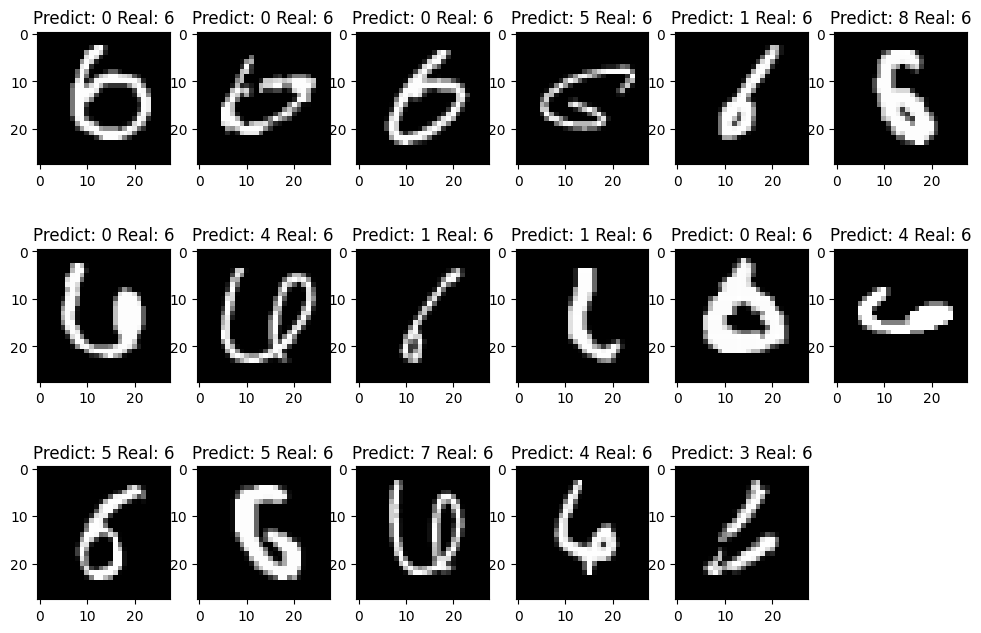

In [36]:
plt.figure(figsize=(12, 8))
index = [259, 445, 965, 1014, 1181, 1182, 1444, 2118, 2135, 2654, 3422, 3520, 4063, 4536, 4814, 6847, 9679]
for i, _x in enumerate(x_test[index], 1):
    plt.subplot(3, 6, i)
    plt.imshow(_x.reshape(28, 28), cmap="gray")
    plt.title(f"Predict: {y_pred_test[index[i - 1]]} Real: {y_test[index[i - 1]]}")